# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, BatchNormalization, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import inspect

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')
data_path = 'gdrive/MyDrive/colab/coursera/getting-started-with-tensor-flow2/data'

Mounted at /content/gdrive


In [3]:
from scipy.io.matlab.mio import whosmat
# Load the dataset from your Drive folder
# !ls gdrive/MyDrive/colab/coursera/getting-started-with-tensor-flow2/data
train = loadmat(f"{data_path}/train_32x32.mat")
test = loadmat(f"{data_path}/test_32x32.mat")

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Extract the training and testing images and labels separately 
# from the train and test dictionaries loaded for you.
train_images = train['X']
train_targets = train['y']
test_images = test['X']
test_targets = test['y']
print(f"Shape before axes swap {train_images.shape}")
train_images = train_images.swapaxes(3,2).swapaxes(2,1).swapaxes(0,1)
test_images = test_images.swapaxes(3,2).swapaxes(2,1).swapaxes(0,1)
print(f"Shape after axes swap {train_images.shape}")

Shape before axes swap (32, 32, 3, 73257)
Shape after axes swap (73257, 32, 32, 3)


In [5]:
# Select a random sample of images and corresponding labels from 
# the dataset (at least 10), and display them in a figure.

def take_sample(count, X, y):
    assert len(X) == len(y)
    
    random_idx = np.random.randint(0, len(X), 30)
    sample_X = X[random_idx,:]
    sample_y = y[random_idx, :]
    return sample_X, sample_y

def plot_images(images, labels):    
    assert len(images) == len(labels)
    
    color_map = "prism"
    
    if images.shape[-1] == 1:
        color_map = "gray"
        images = np.average(images, axis=3)
        
    fig, axes = plt.subplots(2, 15)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap=color_map)
        xlabel = labels[i]
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.rcParams['figure.figsize'] = (17,3.5)
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


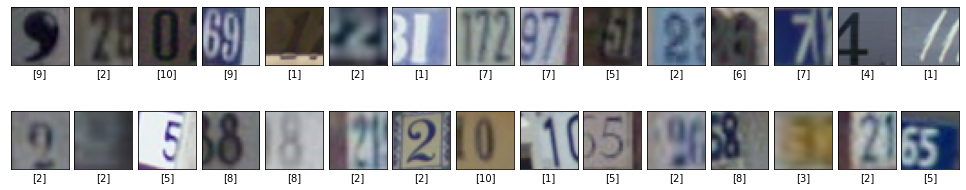

In [9]:
sample_images, sample_targets = take_sample(30, train_images, train_targets)
plot_images(sample_images, sample_targets)

In [7]:
# Convert the training and test images to grayscale by taking the average across all colour channels 
# for each pixel. _Hint: retain the channel dimension, which will now have size 1._

def convert_to_grayscale(images):
    assert images.shape[-1] == 3
    grayscale_images = np.mean(images, axis=3, keepdims=True)
    assert grayscale_images.shape == images.shape[:3] + (1,)
    return grayscale_images

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


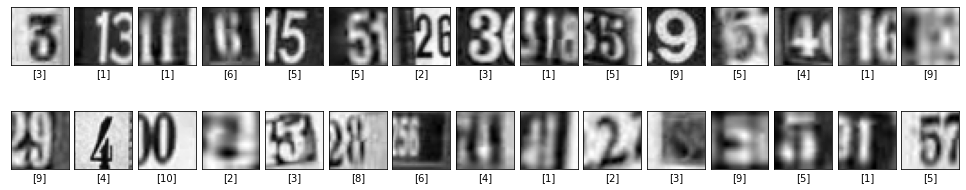

In [8]:
gray_train_images = convert_to_grayscale(train_images)

gray_train_sample, gray_train_sample_targets = take_sample(30, gray_train_images, train_targets)
plot_images(gray_train_sample, gray_train_sample_targets)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
# You should design and build the model yourself. Feel free to experiment with different MLP architectures. 
# Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers.
def get_model_1():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_2():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_3():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_4():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_5():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_6():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_7():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_8():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_9():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

def get_model_10():
    model = Sequential([
        Flatten(input_shape=(32,32,1)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(10),
        Softmax()
    ])
    return model

In [11]:
# Compile and train the model (we recommend a maximum of 30 epochs), 
# making use of both training and validation sets during the training run.
# Your model should track at least one appropriate metric, and use at least 
# two callbacks during training, one of which should be a ModelCheckpoint callback.
# As a guide, you should aim to achieve a final categorical cross entropy training 
# loss of less than 1.0 (the validation loss might be higher).

def get_checkpoint_every_epoch(model_name):
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    EVERY_EPOCH_CHECKPOINT_PATH = f"{data_path}/{model_name}_every_checkpoint/" + "ckpt_{epoch:03d}"

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                filepath=EVERY_EPOCH_CHECKPOINT_PATH, 
                                save_weights_only=True, 
                                save_freq="epoch",
                                verbose=1
    )
    
    return checkpoint
    


def get_checkpoint_best_only(metric_name: str, model_name):
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    BEST_CHECKPOINT_PATH = f"{data_path}/{model_name}_checkpoints_best_only/ckpt"
    checkpoint = ModelCheckpoint(filepath = BEST_CHECKPOINT_PATH,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor=metric_name,
                                verbose=1
                                )
    
    return checkpoint


def get_early_stopping(metric_name: str):
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    callback = EarlyStopping(monitor=metric_name, patience=3)

    return callback
    
def lr_function(epoch, lr):
    return lr * 0.95

def plot_training(history, metric='accuracy'):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    for i, lr in enumerate(history.history['lr']):
        if i % 5 == 0:
            plt.text(i, history.history[metric][i], f"lr:{lr:.6f}")
    
    plt.title(f"{metric.capitalize()} vs. epochs")
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 


In [12]:
def load_model(model_name, input_shape=None):
    model_fn = globals()[f"get_{model_name}"]
    args = inspect.getargspec(model_fn).args
    if len(args) > 0:
        return model_fn(input_shape)
    else:
        return model_fn()

def train(model_name, lr=0.012, epochs=30, lr_fn=lr_function, verbose=True):
    
    checkpoint_every_epoch = get_checkpoint_every_epoch(f"{model_name}_lr_{str(lr)}")
    checkpoint_best_only = get_checkpoint_best_only("loss", f"{model_name}_lr_{str(lr)}")
    early_stopping = get_early_stopping("loss")
    
    model = load_model(model_name, gray_train_images[0].shape)
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=Adam(learning_rate=lr), metrics=["mse","mae", "accuracy"])

    history = model.fit(gray_train_images, 
                        train_targets - 1,
                        batch_size=30,
                        epochs=epochs,
                        validation_split=0.15,
                        callbacks=[
                            tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose=1),
                            checkpoint_every_epoch,
                            checkpoint_best_only,
                            early_stopping], 
                        verbose=verbose)

    plot_training(history, 'accuracy')
    plot_training(history, 'loss')
    
    return model, history

Training output omitted for brevity.
Accuracy: 0.6494507789611816
Loss: 1.1414709091186523



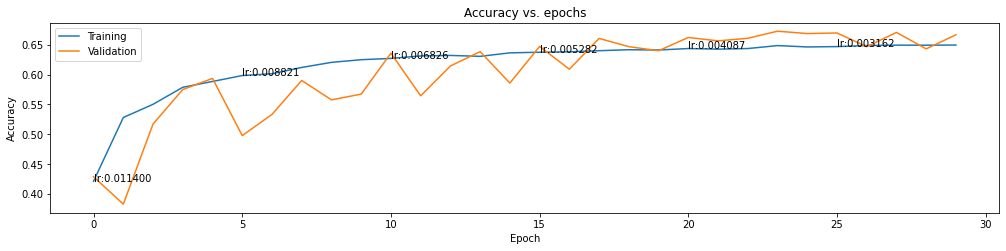

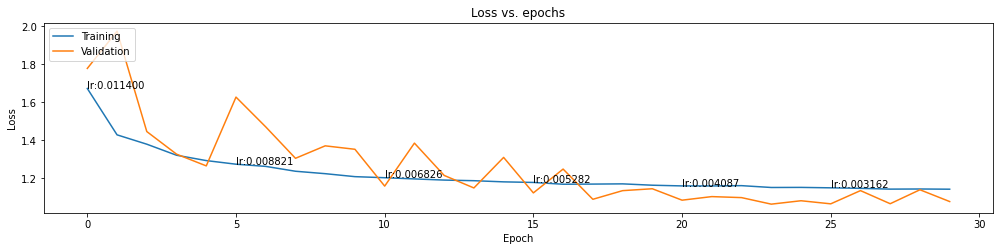

In [29]:
# model_7, history_7 = train("model_7", epochs=30, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_7.history['accuracy'][-1]}")
print(f"Loss: {history_7.history['loss'][-1]}\n")
plot_training(history_7, 'accuracy')
plot_training(history_7, 'loss')

Training output omitted for brevity.
Accuracy: 0.607535183429718
Loss: 1.2575607299804688



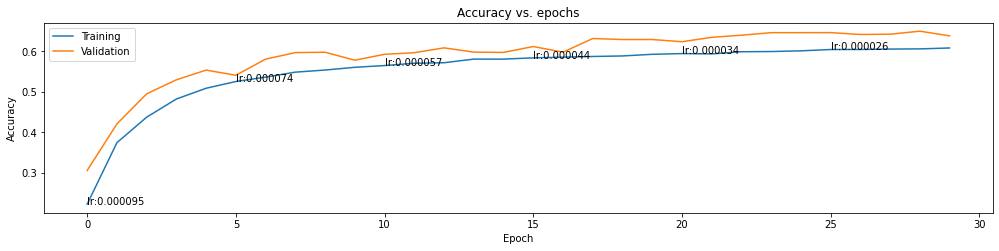

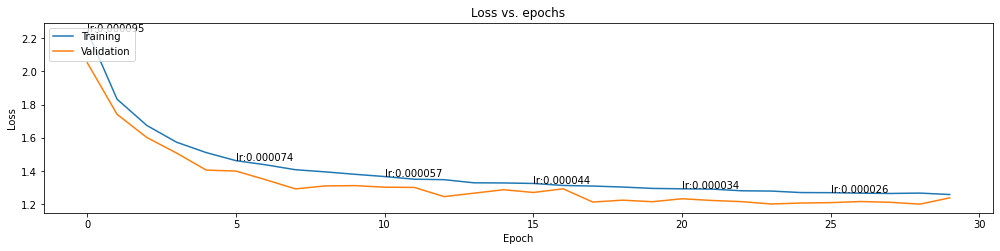

In [28]:
# model_7_lr_e4, history_7_lr_e4 = train("model_7", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_7_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {history_7_lr_e4.history['loss'][-1]}\n")
plot_training(history_7_lr_e4, 'accuracy')
plot_training(history_7_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.6770893335342407
Loss: 1.0444271564483643



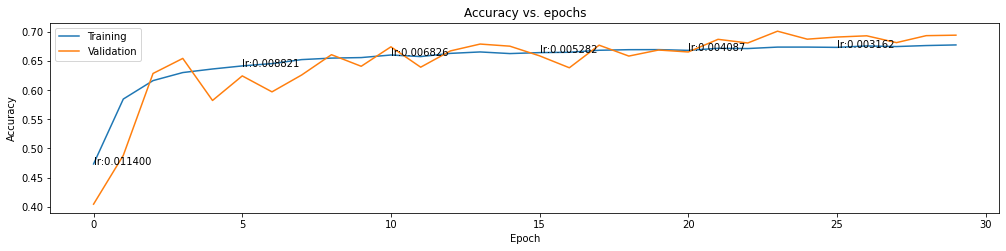

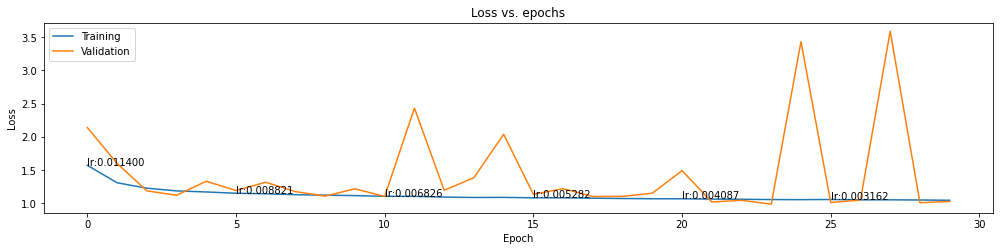

In [32]:
# model_6, history_6 = train("model_6", epochs=30, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_6.history['accuracy'][-1]}")
print(f"Loss: {history_6.history['loss'][-1]}\n")
plot_training(history_6, 'accuracy')
plot_training(history_6, 'loss')

Training output omitted for brevity.
Accuracy: 0.6869981288909912
Loss: 1.0193836688995361



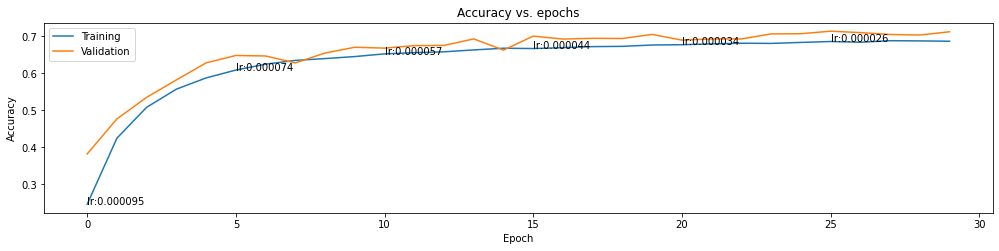

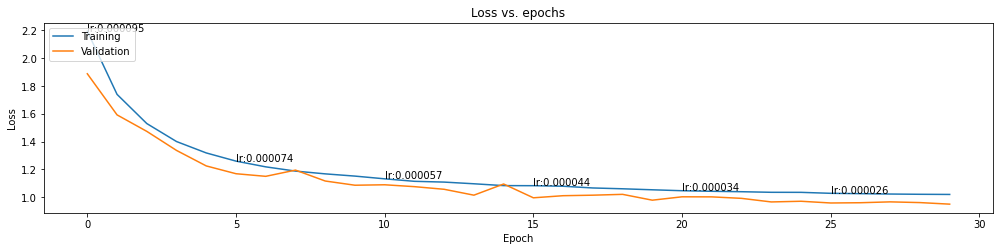

In [34]:
# model_6_lr_e4, history_6_lr_e4 = train("model_6", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_6_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {history_6_lr_e4.history['loss'][-1]}\n")
plot_training(history_6_lr_e4, 'accuracy')
plot_training(history_6_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.6659279465675354
Loss: 1.096746802330017



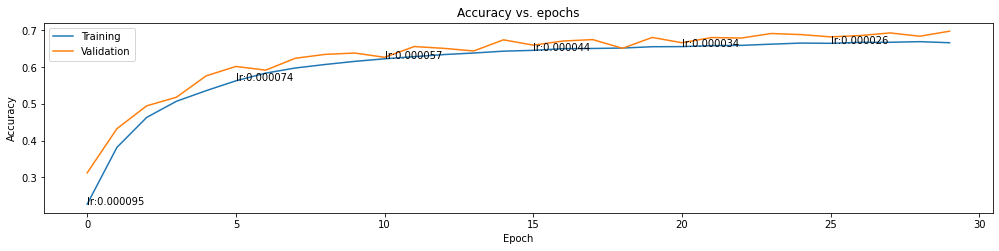

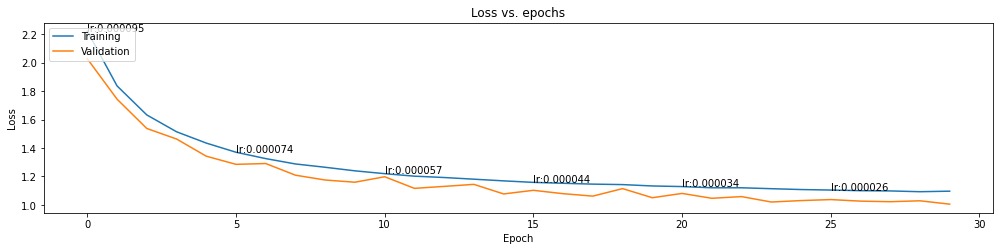

In [37]:
# model_8_lr_e4, history_8_lr_e4 = train("model_8", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_8_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {history_8_lr_e4.history['loss'][-1]}\n")
plot_training(history_8_lr_e4, 'accuracy')
plot_training(history_8_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.6490653157234192
Loss: 1.1477034091949463



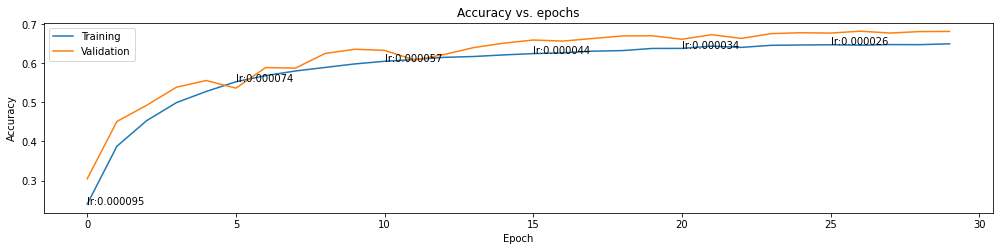

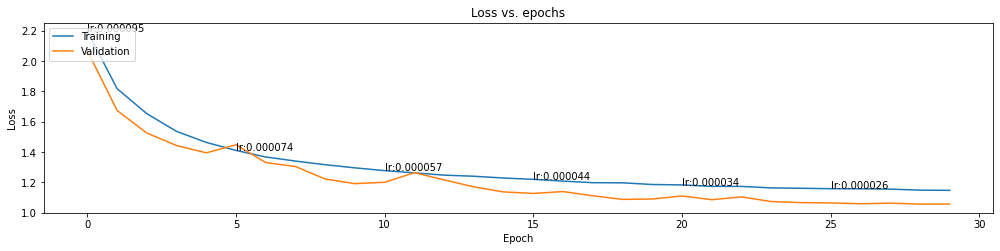

In [38]:
# model_9_lr_e4, history_9_lr_e4 = train("model_9", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {history_9_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {history_9_lr_e4.history['loss'][-1]}\n")
plot_training(history_9_lr_e4, 'accuracy')
plot_training(history_9_lr_e4, 'loss')

### Best MLP model training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 64)                65600     
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_17 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 10)               

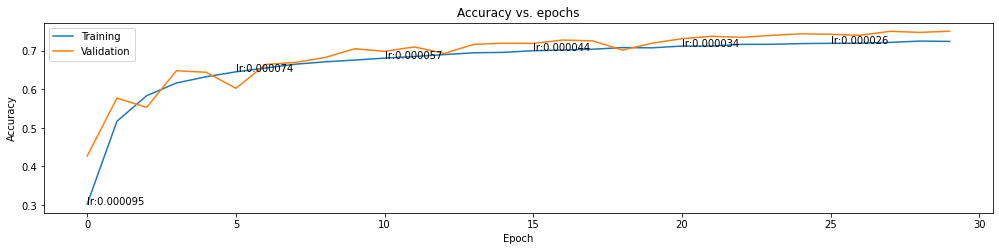

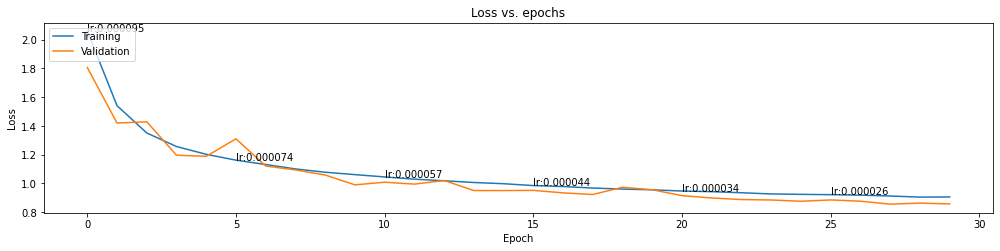

In [39]:
model_10_lr_e4, history_10_lr_e4 = train("model_10", epochs=30, lr=1e-4, verbose=True)

### Load best model

In [ ]:
best_model = get_model_10()
latest = tf.train.latest_checkpoint(f"{data_path}/model_10_lr_0.0001_every_checkpoint")
best_model.load_weights(latest)

In [ ]:
gray_test_images = convert_to_grayscale(test_images)
test_predictions = best_model.predict(gray_test_images)
test_targets_reshaped = test_targets -1 # make the test labels 0 based (-1)


### Calculating loss on test set

In [ ]:
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state(test_targets_reshaped, test_predictions)
m.result().numpy()

1.006672

### Calculating accuracy on test set

In [ ]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_targets_reshaped, test_predictions)
m.result().numpy()

0.7059388

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
def get_cnn_model_1(input_shape):
    model = Sequential([
        Conv2D(8, kernel_size=(4,4), activation='relu', padding='SAME', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((4,4)),
        Dropout(0.2),
        Conv2D(8, kernel_size=(4,4), activation='relu', padding='SAME'),
        BatchNormalization(),
        Dropout(0.2),        
        Flatten(),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return model

def get_cnn_model_2(input_shape):
    model = Sequential([
        Conv2D(32, kernel_size=(4,4), activation='relu', padding='SAME', input_shape=input_shape),
        Dropout(0.2),
        Conv2D(16, kernel_size=(2,2), activation='relu', padding='SAME'),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D((8,8)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    return model

def get_cnn_model_3(input_shape):
    model = Sequential([
        Conv2D(8, kernel_size=(4,4), activation='relu', padding='SAME', input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        MaxPooling2D((8,8)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    return model

def get_cnn_model_2_regularized(input_shape):
    weight_decay = 0.001
    model = Sequential([
        Conv2D(32, kernel_size=(4,4), activation='relu', padding='SAME', 
               input_shape=input_shape, 
               kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        Dropout(0.2),
        Conv2D(16, kernel_size=(2,2), activation='relu', padding='SAME',
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D((8,8)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    return model

def get_cnn_model_4_regularized(input_shape):
    weight_decay = 0.001
    model = Sequential([
        Conv2D(64, kernel_size=(4,4), activation='relu', padding='SAME', 
               input_shape=input_shape, 
               kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        Dropout(0.2),
        BatchNormalization(),
        Conv2D(32, kernel_size=(2,2), activation='relu', padding='SAME',
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        Dropout(0.2),
        BatchNormalization(),
        MaxPooling2D((8,8)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    return model

Training output omitted for brevity.
Accuracy: 0.7364617586135864
Loss: 0.8304417133331299



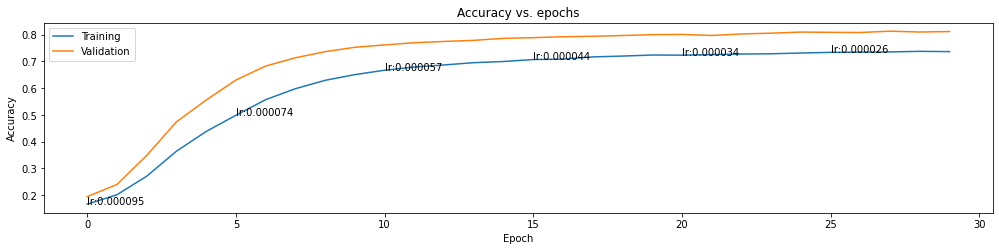

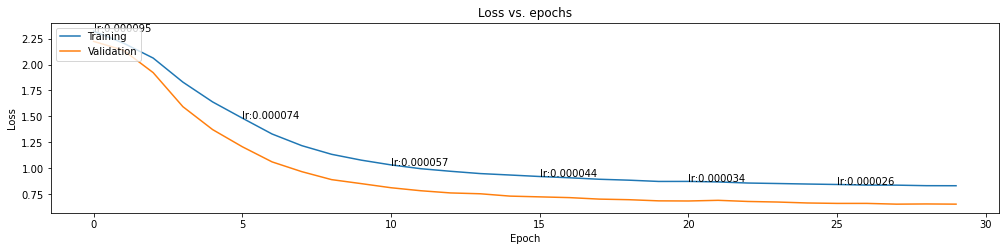

In [17]:
# cnn_model_1_lr_e4, cnn_history_1_lr_e4 = train("cnn_model_1", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {cnn_history_1_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {cnn_history_1_lr_e4.history['loss'][-1]}\n")
plot_training(cnn_history_1_lr_e4, 'accuracy')
plot_training(cnn_history_1_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.7636346220970154
Loss: 0.7871495485305786



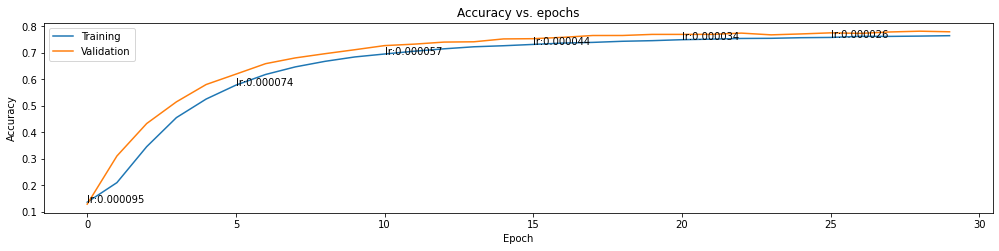

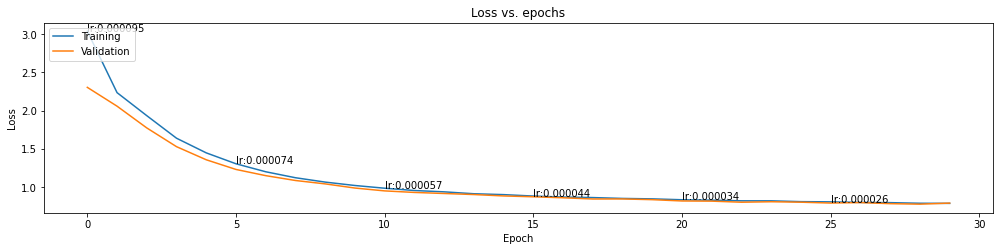

In [23]:
# cnn_model_2_lr_e4, cnn_history_2_lr_e4 = train("cnn_model_2", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {cnn_history_2_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {cnn_history_2_lr_e4.history['loss'][-1]}\n")
plot_training(cnn_history_2_lr_e4, 'accuracy')
plot_training(cnn_history_2_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.6500449776649475
Loss: 1.1338757276535034



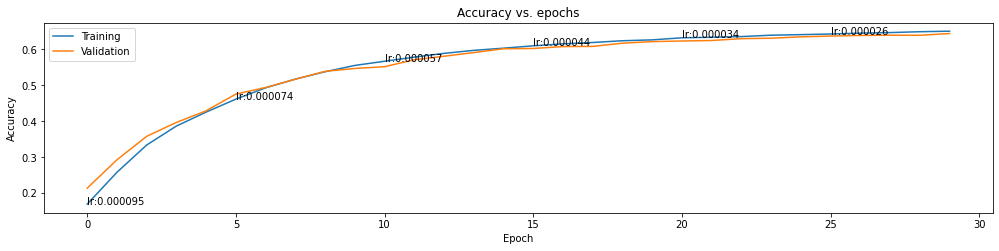

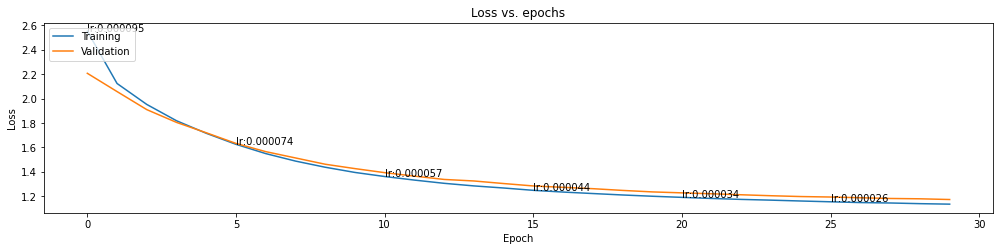

In [22]:
# cnn_model_3_lr_e4, cnn_history_3_lr_e4 = train("cnn_model_3", epochs=30, lr=1e-4)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {cnn_history_3_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {cnn_history_3_lr_e4.history['loss'][-1]}\n")
plot_training(cnn_history_3_lr_e4, 'accuracy')
plot_training(cnn_history_3_lr_e4, 'loss')

Training output omitted for brevity.
Accuracy: 0.7653048038482666
Loss: 0.8028132915496826



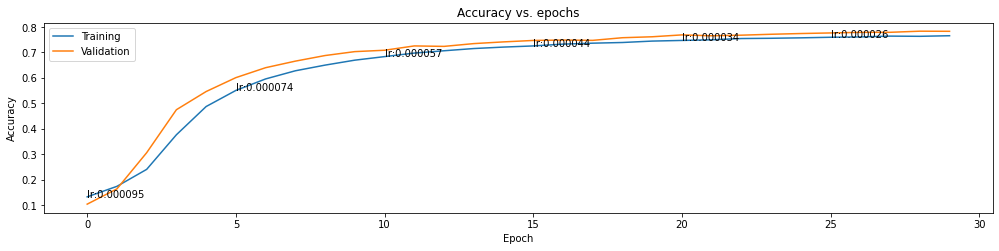

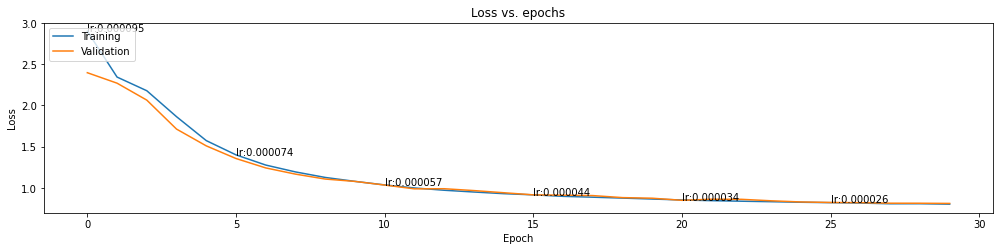

In [21]:
# cnn_model_2_reg_lr_e4, cnn_history_2_reg_lr_e4 = train("cnn_model_2_regularized", epochs=30, lr=1e-4, verbose=False)
print(f"Training output omitted for brevity.")
print(f"Accuracy: {cnn_history_2_reg_lr_e4.history['accuracy'][-1]}")
print(f"Loss: {cnn_history_2_reg_lr_e4.history['loss'][-1]}\n")
plot_training(cnn_history_2_reg_lr_e4, 'accuracy')
plot_training(cnn_history_2_reg_lr_e4, 'loss')

### Best CNN model training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1088      
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

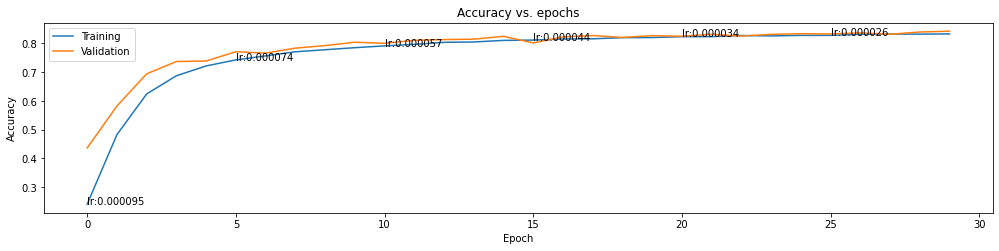

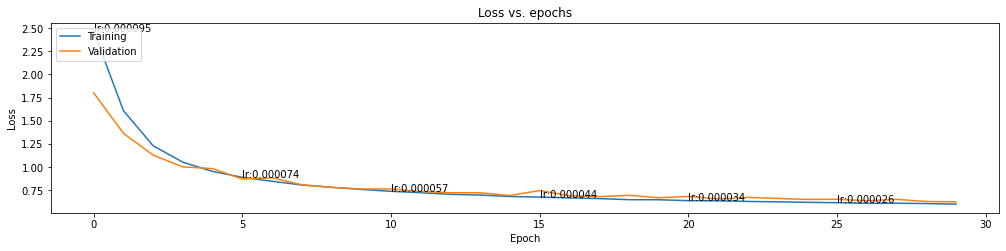

In [24]:
cnn_model_4_reg_lr_e4, cnn_history_4_reg_lr_e4 = train("cnn_model_4_regularized", epochs=30, lr=1e-4, verbose=False)

In [ ]:
gray_test_images = convert_to_grayscale(test_images)

best_cnn_model = get_cnn_model_4_regularized(gray_test_images[0].shape)
latest = tf.train.latest_checkpoint(f"{data_path}/cnn_model_4_regularized_lr_0.0001_every_checkpoint")
best_cnn_model.load_weights(latest)

test_predictions = best_cnn_model.predict(gray_test_images)
test_targets_reshaped = test_targets -1 # make the test labels 0 based (-1)

### Calculating best CNN model loss

In [ ]:
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state(test_targets_reshaped, test_predictions)
m.result().numpy()

0.6391569

### Calculating best CNN model accuracy

In [ ]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_targets_reshaped, test_predictions)
m.result().numpy()

0.8285956

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
gray_test_images = convert_to_grayscale(test_images)

best_mlp_model = get_model_10()
latest = tf.train.latest_checkpoint(f"{data_path}/model_10_lr_0.0001_every_checkpoint")
best_mlp_model.load_weights(latest)

best_cnn_model = get_cnn_model_4_regularized(gray_test_images[0].shape)
latest = tf.train.latest_checkpoint(f"{data_path}/cnn_model_4_regularized_lr_0.0001_every_checkpoint")
best_cnn_model.load_weights(latest)


In [ ]:
img_indexes = np.random.choice(len(gray_test_images), 5, replace=False)
sample_images = gray_test_images[img_indexes]
sample_targets = test_targets[img_indexes]

In [ ]:
def plot_images_and_model_distr(images, labels, model):    
    assert len(images) == len(labels)
    
    images_for_plot = np.average(images, axis=3)
    predictions = model.predict(images)

        
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    print(axes.flat)
    for i, ax in enumerate(axes.flat):
        if i < 5:
          ax.imshow(images_for_plot[i], cmap="gray")
          xlabel = labels[i]
          ax.set_xlabel(f"Real label: {xlabel}")
        elif i < 10:
          e = i - 5
          ax.bar(np.arange(10), predictions[e])
          ax.set_xlabel(f"Predicted label: {np.argmax(predictions[e]) + 1}")
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.rcParams['figure.figsize'] = (17,5.5)
    plt.show()

### MLP model prediction of 5 sample images

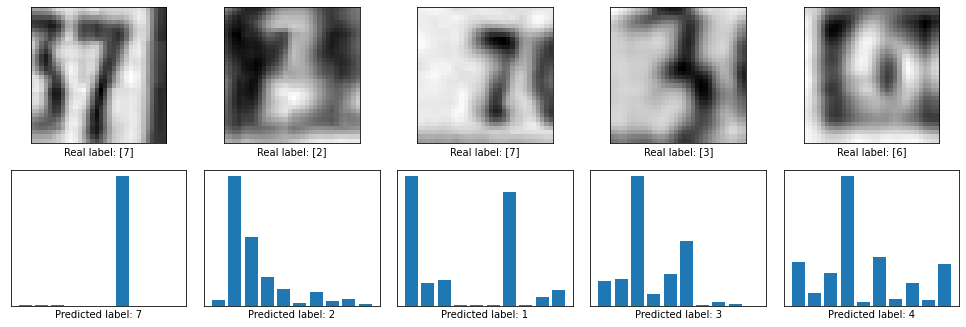

In [ ]:
plot_images_and_model_distr(sample_images, sample_targets, best_mlp_model)

### CNN model prediction of 5 sample images

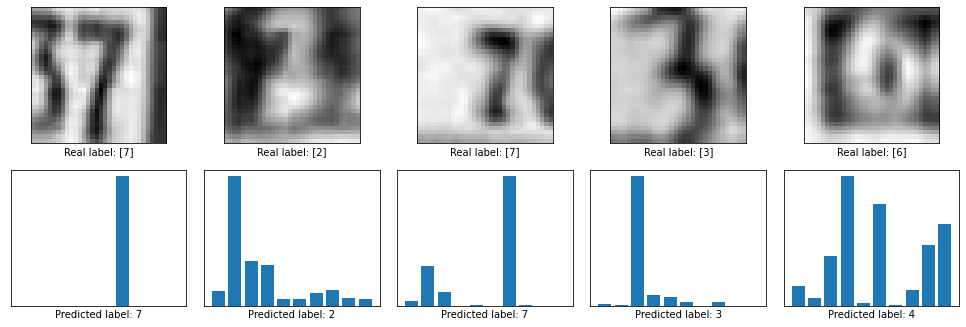

In [ ]:
plot_images_and_model_distr(sample_images, sample_targets, best_cnn_model)